In [1]:
import numpy as np
from itertools import product
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

**generate_hooks**     
* Generates the position of hooks, given a particular number of hooks, wheel pixel size, and hook pixel size.
* Creates 2 lists of positions (one for the anticlockwise side, one for the clockwise), and weaves them together so that the order they appear in the final output is the order of nodes anticlockwise around the frame.

**through_pixels**
* Given 2 hooks, generates a list of pixels that the line connecting them runs through.

**build_through_pixels_dict**
* Uses `through_pixels` to build up a dictionary of all possible lines connecting 2 hooks.
* Can be run at the start of a project, and doesn't need to be run again.
* Prints out an ongoing estimate of how much time is left.

In [2]:
def generate_hooks(n_hooks, wheel_pixel_size, hook_pixel_size):
    
    r = (wheel_pixel_size / 2) - 1
    
    theta = np.arange(n_hooks, dtype="float64") / n_hooks * (2 * np.pi)
    
    epsilon = np.arcsin(hook_pixel_size / wheel_pixel_size)
    
    theta_acw = theta.copy() + epsilon
    theta_cw = theta.copy() - epsilon
    
    theta = np.stack((theta_cw, theta_acw)).ravel("F")
    
    x = r * (1 + np.cos(theta)) + 0.5
    y = r * (1 + np.sin(theta)) + 0.5
    
    return np.array((x,y)).T


def through_pixels(p0, p1):
    
    d = max(int(((p0[0]-p1[0])**2 + (p0[1]-p1[1])**2) ** 0.5), 1)
    
    pixels = p0 + (p1-p0) * np.array([np.arange(d+1), np.arange(d+1)]).T / d
    pixels = np.unique(np.round(pixels), axis=0).astype(int)
    
    return pixels


def build_through_pixels_dict(n_hooks, wheel_pixel_size, hook_pixel_size):

    n_hook_sides = n_hooks * 2

    l = [(0,1)]
    for j in range(n_hook_sides):
        for i in range(j):
            if j-i > 10 and j-i < (n_hook_sides - 10):
                l.append((i, j))
    
    random_order = np.random.choice(len(l),len(l),replace=False)
    
    d = {}    
    t_list = []
    t0 = time.time()
    
    for n in range(len(l)):
        (i, j) = l[random_order[n]]
        p0, p1 = hooks[i], hooks[j]
        d[(i,j)] = through_pixels(p0, p1)
        
        t = time.time() - t0
        t_left = t * (len(l) - n - 1) / (n + 1)
        print(f"time left = {time.strftime('%M:%S', time.gmtime(t_left))}", end="\r")
    
    clear_output()
    return d

**fitness**
* Measures how much a line improves the image. Improvement is average difference in penalty between the old and new images.
  * **Penalty** depends on the lightness_penalty, w, w_pos and w_neg parameters. At its simplest level, penalty is the sum of the absolute values of all the pixels in the image, but: 
    * `lightness_penalty` applies a scale factor to the penalties for negative pixels (e.g. if it was less than 1, the algorithm prefers drawing too many lines than too few).
    * `w` is an array, just like image. It assigns an importance weighting to pixels. A black pixel means that area has full weighting in the penalty calculation, but a while pixel means that area is completely ignored.
    * `w_pos` and `w_neg` are similar to w, except they distinguish between positive and negative pixels. Note that we can't use this mode and the previous mode w, so we must have either w set to False, or both w_pos and w_neg set to False.
  * **Average** depends on the `line_norm_mode` parameter. There are 3 possible modes: "none" (just the sum is taken, no average), "length" (penalty is divided by length of line), or "weighted length" (penalty is divided by the sum of weightings). Note the latter mode only makes sense if you are using a weigting. If using w_pos and w_neg, it defaults to summing over w_pos.

**optimise_fitness**
* Process of adding a new line is as follows:
    1. Generates random lines (ensuring they aren't the same line, or connecting hooks too close to each other), then finds the line with the best fitness.
    2. Subtracts this line from the image.
    3. Returns the new image, the best line, and a boolean that says whether a line is being added or removed.

In [3]:
def fitness(image, i, j, darkness, lightness_penalty, w, w_pos, w_neg, line_norm_mode, adding):
    
    pixels = through_pixels_dict[(i, j)]
    
    old_pixel_values = image[tuple(pixels.T)]
    
    if adding:
        new_pixel_values = old_pixel_values - darkness
    else:
        new_pixel_values = old_pixel_values + darkness

    if type(w) == bool and type(w_pos) == bool:
        new_penalty = new_pixel_values.sum() - (1 + lightness_penalty) * new_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_pixel_values.sum() - (1 + lightness_penalty) * old_pixel_values[old_pixel_values < 0].sum()
    elif type(w_pos) == bool:
        pixel_weightings = w[tuple(pixels.T)]
        new_w_pixel_values = new_pixel_values * pixel_weightings
        old_w_pixel_values = old_pixel_values * pixel_weightings
        new_penalty = new_w_pixel_values.sum() - (1 + lightness_penalty) * new_w_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_w_pixel_values.sum() - (1 + lightness_penalty) * old_w_pixel_values[old_pixel_values < 0].sum()
    elif type(w) == bool:
        pos_pixel_weightings = w_pos[tuple(pixels.T)]
        neg_pixel_weightings = w_neg[tuple(pixels.T)]
        new_wpos_pixel_values = new_pixel_values * pos_pixel_weightings
        new_wneg_pixel_values = new_pixel_values * neg_pixel_weightings
        old_wpos_pixel_values = old_pixel_values * pos_pixel_weightings
        old_wneg_pixel_values = old_pixel_values * neg_pixel_weightings
        new_penalty = new_wpos_pixel_values[new_pixel_values > 0].sum() \
                      - lightness_penalty * new_wneg_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_wpos_pixel_values[old_pixel_values > 0].sum() \
                      - lightness_penalty * old_wneg_pixel_values[old_pixel_values < 0].sum()

    if line_norm_mode == "length":
        line_norm = len(pixels)
    elif line_norm_mode == "weighted length":
        if type(w_pos) == bool:
            line_norm = sum(pixel_weightings)
        else:
            line_norm = sum(pos_pixel_weightings)
    elif line_norm_mode == "none":
        line_norm = 1
     
    if line_norm == 0:
        return 0
    else:
        return (new_penalty - old_penalty) / line_norm


def optimise_fitness(image, n_random, darkness, lightness_penalty, n_hooks, list_of_lines, w, w_pos, w_neg, line_norm_mode):
    
    n_hook_sides = n_hooks * 2
    
    rand_numbers = np.random.choice(n_hook_sides**2, n_random, replace=False)

    rand_lines = [sorted((int(i/n_hook_sides), i%n_hook_sides)) for i in rand_numbers]
        
    best_fitness = 0
    best_line = (0,1)

    for line in rand_lines:
            
        (i, j) = line
            
        if j-i > 10 and j-i < (n_hook_sides - 10):
            
            new_fitness = fitness(image, i, j, darkness, lightness_penalty, w, w_pos, w_neg, line_norm_mode, 
                                  adding = line not in list_of_lines)
            
            if new_fitness <= best_fitness:
                
                best_fitness = new_fitness
                best_line = line

    p0, p1 = hooks[best_line[0]], hooks[best_line[1]]
    
    adding = best_line not in list_of_lines    
    for p in through_pixels_dict[tuple(best_line)]:
        if adding:
            image[p[0],p[1]] -= darkness
        else:
            image[p[0],p[1]] += darkness   

    return image, best_line, adding

**find_lines**
* Calls `optimise_fitness` multiple times to draw a set of lines.
* Updates the image and the list of lines with each line drawn.
* Every 20 lines drawn, prints output that describes the progress of the algorithm (including average penalty, current runtime, and projected total runtime).

**get_penalty**
* Calculates the total penalty of the image.
* This is different depending on whether importance weightings are being used.

In [4]:
def find_lines(image, n_lines, n_random, darkness, lightness_penalty, line_norm_mode, w=False, w_pos=False, w_neg=False):
    
    list_of_lines = []
    
    for i in range(n_lines):
        
        if i == 0:
            t0 = time.time()
            initial_penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
            initial_avg_penalty = '{:.2f}'.format(initial_penalty / (wheel_pixel_size ** 2))
        elif i%50 == 0:
            t_so_far = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
            t_left = time.strftime('%H:%M:%S', time.gmtime((time.time() - t0) * (n_lines - i) / i))   
            penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
            avg_penalty = '{:.2f}'.format(penalty / (wheel_pixel_size ** 2))
            print(f"{len(list_of_lines)}/{i}, average penalty = {avg_penalty}/{initial_avg_penalty}, \
time = {t_so_far}, time left = {t_left}", end="\r")                
        
        image, line, adding = optimise_fitness(image, n_random, darkness, lightness_penalty, n_hooks, list_of_lines, 
                                                  w, w_pos, w_neg, line_norm_mode)
        
        if adding:
            list_of_lines.append(line)
        else:
            list_of_lines.remove(line)
    
    clear_output()
    
    penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
    avg_penalty = '{:.2f}'.format(penalty / (wheel_pixel_size ** 2))
    print(f"{len(list_of_lines)}/{n_lines}, average penalty = {avg_penalty}/{initial_avg_penalty}")
    print("time = " + time.strftime('%H:%M:%S', time.gmtime(time.time() - t0)))
    
    return list_of_lines
        

def get_penalty(image, lightness_penalty, w, w_pos, w_neg):
    
    if type(w) == bool and type(w_pos) == bool:
        return image.sum() - (1 + lightness_penalty) * image[image<0].sum()
    elif type(w_pos) == bool:
        image_w = image * w
        return image_w.sum() - (1 + lightness_penalty) * image_w[image<0].sum()
    elif type(w) == bool:
        image_wpos = image * w_pos
        image_wneg = image * w_neg
        return image_wpos[image>0].sum() - lightness_penalty * image_wneg[image<0].sum() 

**prepare_image**
* Takes a jpeg or png image file, and converts it into a square array of bytes.
* `colour` (boolean) determines whether image is meant to have its colour read rather than darkness. If True then the pixel values will represent the saturation of the image, if False then they will represent the darkness.
* `weighting` (boolean) determines whether image is meant to be an importance weighting. If True, the array has values between 0 and 1, where black = 1 = maximum importance, and white = 0 = no importance).

**display_images**
* Displays images (i.e. output from `prepare_image`) inline, in a nice format.

In [5]:
def prepare_image(file_name, colour=False, weighting=False):
    
    image = Image.open(file_name).resize((wheel_pixel_size, wheel_pixel_size))
    
    if colour:
        image = np.array(image.convert(mode="HSV").getdata()).reshape((wheel_pixel_size, wheel_pixel_size,3))[:,:,1]
    elif weighting:     
        image = 1 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size)) / 255
    else:
        image = 255 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size))

    coords = np.array(list(product(range(wheel_pixel_size), range(wheel_pixel_size))))
    x_coords = coords.T[0]
    y_coords = coords.T[1]
    coords_distance_from_centre = np.sqrt((x_coords - (wheel_pixel_size-1)*0.5)**2 + (y_coords - (wheel_pixel_size-1)*0.5)**2)
    mask = np.array(coords_distance_from_centre > wheel_pixel_size*0.5)
    mask = np.reshape(mask, (-1, wheel_pixel_size))
    image[mask] = 0                             
            
    return image.T[:,::-1]


def display_images(image_list):
    
    fig, axs = plt.subplots(1,len(image_list),figsize=(30,30));
    for (i,j) in zip(range(len(image_list)), image_list):
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].imshow(j[:,::-1].T, cmap=plt.get_cmap("Greys"));

**save_plot**
* Saves the plot of lines as a jpeg with a specified name.
* It can also save multicoloured images; colours are added in the order they appear in the list.
* The colour tuples are interpreted using RGB format.

**save_plot_progress**
* Saves multiple plots midway through the construction process.
* `proportion_list` contains a list of floats between 0 and 1, representing the proportion of lines you want to draw (e.g. if the list was \[0.5,1\], then 2 plots would be saved, one with half the lines drawn and one completely finished.

In [6]:
def save_plot(list_coloured_lines, list_colours, file_name, size):
        
    new_hooks = generate_hooks(n_hooks, size, hook_pixel_size)
    
    for i in range(len(new_hooks)):
        new_hooks[i] = [new_hooks[i][0], size - new_hooks[i][1]]
    
    thread_image = Image.new('RGB', (size,size), (255,255,255))
    draw = ImageDraw.Draw(thread_image)
    
    for (lines, colour) in zip(list_coloured_lines, list_colours):
        pixel_pairs = [(new_hooks[n[0]], new_hooks[n[1]]) for n in lines]
        for j in pixel_pairs:
            draw.line((tuple(j[0]), tuple(j[1])), fill=colour)
        
    thread_image.save(file_name + ".jpg", format="JPEG")
    
    
def save_plot_progress(list_coloured_lines, list_colours, file_name, size, proportion_list):
    
    for prop in proportion_list:
        file_name_temp = f"{file_name} {int(100*prop)}%"
        lines_temp = list_coloured_lines[-1][:int(len(list_coloured_lines[-1])*prop)]
        list_coloured_lines_temp = list_coloured_lines[:-1] + [lines_temp]
        save_plot(list_coloured_lines_temp, list_colours, file_name_temp, size=size)

* 
* 
* 

In [7]:
wheel_real_size = 0.58
hook_real_size = 6 * (10**-3)
wheel_pixel_size = 3500
hook_pixel_size = (hook_real_size / wheel_real_size) * wheel_pixel_size 
n_hooks = 250

hooks = generate_hooks(n_hooks, wheel_pixel_size, hook_pixel_size)
through_pixels_dict = build_through_pixels_dict(n_hooks, wheel_pixel_size, hook_pixel_size)

In [8]:
image_m = prepare_image("bowie_monochrome.jpg")

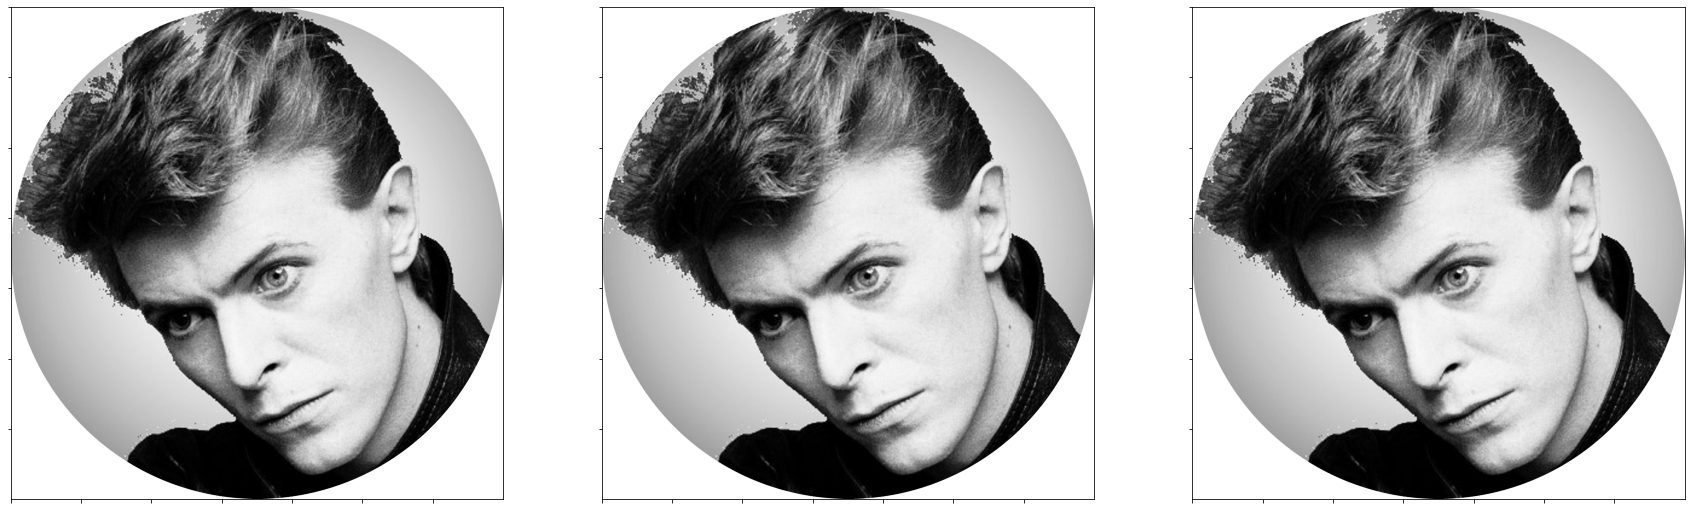

In [9]:
image_list = [image_m] * 3
display_images(image_list)

In [10]:
lines = find_lines(image_m, n_lines=4500, n_random=250, 
                   darkness=190, lightness_penalty=0.35, 
                   line_norm_mode="length")

4174/4500, average penalty = 62.72/108.11
time = 00:07:01


In [13]:
save_plot_progress([lines], [(0,0,0)], "bowie heroes", 3500, [0.2, 0.4, 0.6, 0.8, 1])

* 
* 
* 

**edge**
* This class introduces some useful features of edges:
  * Edges each have 2 nodes, A and B. Since each node refers to a particular side of a particular hook, the nodes have a `vertex` and `direction` number (referring to the hook and the side individually).
  * `backwards` flips around the nodes of an edge.
  * `connected` tests whether an edge is in sequence with another edge (i.e. you can trace them out, one after the other, with a single piece of thread).
  * `next_edges` takes an edge and a list of edges, and returns all edges in the list which are in sequence with the first edge. 

In [14]:
class edge():
    
    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.A_vertex = int(A/2)
        self.B_vertex = int(B/2)
        self.A_direction = A%2
        self.B_direction = B%2
        
    def __repr__(self):
        return ("({}, {})".format(self.A, self.B))
    
    def __eq__(self, other):
        return str(self) == str(other)
    
    def backwards(self):
        return edge(self.B, self.A)
    
    def connected(self, e):
        return self.B_vertex == e.A_vertex and self.B_direction != e.A_direction
        
    def next_edges(self, edge_list):
        
        forwards_edge_list = [e for e in edge_list if self.connected(e)]
        backwards_edge_list = [e.backwards() for e in edge_list if self.connected(e.backwards())]
        
        edge_list = forwards_edge_list + backwards_edge_list
        
        return edge_list

**extra_edges_parity_correct**
* Given a list of edges, returns a list of extra edges that are needed to parity-correct the original list (i.e. make sure every hook has the same number of edges on either side).
* The extra edges are chosen in stages, in a way that minimises the difficulty of the manual threading process.

**get_closest_pair**
* Used in the `extra_edges_parity_correct` algorithm, to find the closest 0-1 pair to match up.

In [15]:
def extra_edges_parity_correct(edge_list, n_vertices, verbose=False):
        
    d = {n : 0 for n in range(n_vertices)}
    
    for e in edge_list:
        
        if e.A_direction == 0:
            d[e.A_vertex] -= 1
        elif e.A_direction == 1:
            d[e.A_vertex] += 1
    
        if e.B_direction == 0:
            d[e.B_vertex] -= 1
        elif e.B_direction == 1:
            d[e.B_vertex] += 1
    
    extra_edges = []
    
    # First while loop adds edges until the number that need 0-connections is same as the number that need 1-connections.
    while True:
        s0 = sum([max(i,0) for i in d.values()])
        s1 = sum([-min(i,0) for i in d.values()])
        if s0 == s1:
            break
        elif s0 > s1:
            need_a_zero = [i for i in d.keys() if d[i] > 0]
            a, b, distance = get_closest_pair(need_a_zero, need_a_zero, n_vertices)
            d[a] -= 1
            d[b] -=1
            A = 2*a
            B = 2*b
            extra_edges.append(edge(A,B))
        elif s1 > s0:           
            need_a_one = [i for i in d.keys() if d[i] < 0]
            a, b, distance = get_closest_pair(need_a_one, need_a_one, n_vertices)
            d[a] += 1
            d[b] +=1
            A = 2*a+1
            B = 2*b+1
            extra_edges.append(edge(A,B))
        if verbose:
            print("1st stage: pairing {}, {}, with distance = {}".format(A, B, distance))
        
    # Second while loop connects the closest pair that need an extra 0-connection and 1-connection respectively
    # (close in the sense that the hook needing a 0 should be a short distance anticlockwise from the hook needing a 1).
    while sum([abs(i) for i in d.values()]) > 0:      
        need_a_zero = [n for n in d.keys() if d[n] > 0]
        need_a_one = [n for n in d.keys() if d[n] < 0]
        a, b, distance = get_closest_pair(need_a_zero, need_a_one, n_vertices) #see cell below
        d[a] -= 1
        d[b] += 1
        A = 2*a
        B = 2*b + 1
        extra_edges.append(edge(A,B))
        if verbose:
            print("2nd stage: pairing {}, {}, with distance = {}".format(A, B, distance))

    return extra_edges


def get_closest_pair(need_a_zero, need_a_one, n_vertices):
    
    best_distance = n_vertices
    
    for a in need_a_zero:
        for b in need_a_one:
            new_distance = (a-b)%n_vertices
            if new_distance < best_distance and new_distance != 0:
                best_distance = new_distance
                best_a = a
                best_b = b

    return (best_a, best_b, best_distance)

**extra_edges_connect_graph**
* Adds extra edges so that the graph is connected.
* Does this by finding 2 hooks in disconnected islands that are adjacant, and joining them using a double bridge.

**add_connected_vertex**
* Takes a set of vertices and an edge list, and looks for a vertex not currently in the set that can be connected to the rest of the set using one of the edges in the list. 
* If it finds such a vertex, it adds it to the set.
* Returns the new set, as well as a boolean indicating whether an edge has been successfully added.

**get_adjacant_vertices**
* Takes a set of vertices and its compliment, and returns a pair of vertices (in set and compliment respectively) that are a distance of 1 apart from each other.

In [16]:
def extra_edges_connect_graph(edge_list):
    
    full_vertex_set = set()
    for i in edge_list:
        full_vertex_set.add(i.A_vertex)
        full_vertex_set.add(i.B_vertex)
        
    connected_vertex_set = set([edge_list[0].A_vertex, edge_list[0].B_vertex])
    
    extra_edges = []
    
    while len(connected_vertex_set) < len(full_vertex_set):
        
        connected_vertex_set, found_new_vertex = add_connected_vertex(connected_vertex_set, edge_list)
                
        if not found_new_vertex:
            
            v0, v1 = get_adjacant_vertices(connected_vertex_set, full_vertex_set - connected_vertex_set)
            
            extra_edges += [edge(2*v0, 2*v1), edge(2*v0+1, 2*v1+1)]
            
            connected_vertex_set.add(v0)
            connected_vertex_set.add(v1)
            
    return extra_edges


def add_connected_vertex(conected_vertex_set, edge_list):

    for i in edge_list:
        
        if (i.A_vertex in conected_vertex_set) ^ (i.B_vertex in conected_vertex_set):
                
            conected_vertex_set.add(i.A_vertex)
            conected_vertex_set.add(i.B_vertex)
            return (conected_vertex_set, True)
    
    return (conected_vertex_set, False)


def get_adjacant_vertices(s, t):

    for i in s:
        for j in t:
            if abs(i-j) == 1:
                return (i, j) 

**create_cycle**
* Creates a path from edges in edge_list, starting from first_edge. 
* Returns path, and new reduced edge_list.
* Note, the path is only guaranteed to be a cycle if edge_list isn't parity corrected.

**add_cycle**
* Given a cycle and edge_list, goes through the cycle trying to find a place to insert a new cycle (which only uses edges from edge_list).
* Once it finds a place, it inserts a cycle, and returns the new extended cycle, and the new reduced edge_list.
* Note, a cycle that can be added is only guaranteed to exist if edge_list is connected.

**create_full_cycle**
* Takes edge_list, and keeps adding cycles to it using `add_cycle`, until all edges have been added.
* Note, if edge_list isn't parity corrected or isn't connected, this function will break.

In [17]:
def create_cycle(edge_list, first_edge):
    
    cycle = [first_edge]
    
    while True:  
        try:
            next_edge = cycle[-1].next_edges(edge_list)[0]
            cycle.append(next_edge)
            if next_edge in edge_list:
                edge_list.remove(next_edge)
            else:
                next_edge = next_edge.backwards()
                edge_list.remove(next_edge)
        except:
            return cycle, edge_list
        
        
def add_cycle(cycle, edge_list):
    
    for i in range(len(cycle)):
        
        cycle = [cycle[-1]] + cycle[:-1]
        edge_list_copy = edge_list
        new_cycle, edge_list_copy = create_cycle(edge_list_copy, cycle[-1])
        if len(new_cycle) > 1:
            return cycle + new_cycle[1:], edge_list_copy
    
    
def create_full_cycle(edge_list):
    
    cycle, edge_list = create_cycle(edge_list[1:], edge_list[0])
    
    while len(edge_list) > 0:
        cycle, edge_list = add_cycle(cycle, edge_list)
    
    return cycle

**edges_to_output**
* Takes in a list of edges, and:
    * Adds edges so they are parity-corrected and connected
    * Uses all the other functions to create a full cycle.
    * Cuts down unnecessary outside edges (see function `cut_down`).
    * Presents the output in a form for maunal threading.

**cut_down**
* Removes sequences of multiple "outside" strings, replacing them with one direct string.

In [18]:
def edges_to_output(line_list):
    
    edge_list = [edge(i[0],i[1]) for i in line_list if type(i) == list]
        
    correction_edges = extra_edges_parity_correct(edge_list, n_hooks)
    correction_edges += extra_edges_connect_graph(edge_list + correction_edges)
    
    full_cycle = create_full_cycle(edge_list + correction_edges)
    
    l = [0] * len(full_cycle)
    
    for i in correction_edges:
        for j in range(len(full_cycle)):
            if (i == full_cycle[j] or i.backwards() == full_cycle[j]) and l[j] == 0:
                l[j] = 1
                break
                        
    full_cycle, l = cut_down(full_cycle, l)
        
    l = [0] + l[:-1]

    output = []
    
    first_hook = True
        
    for i in zip(full_cycle, l):
        
        n1 = i[0].A_vertex   
        
        if first_hook:
            n2 = i[0].A_direction
            first_hook = False
        else:
            n2 = (i[0].A_direction + 1) % 2
        
        if i[1] == 1:
            n3 = " outside"
        else:
            n3 = ""
            
        output.append("{}-{}{}".format(n1, n2, n3))
    
    return full_cycle, output


def cut_down(full_cycle, l):
    
    for i in range(len(l)-1):
                
        if l[i] == 1 and l[i+1] == 1:
            new_full_cycle = full_cycle[:i] + [edge(full_cycle[i].A, full_cycle[i+1].B)] + full_cycle[i+2:]
            new_l = l[:i] + [1] + l[i+2:]
            return cut_down(new_full_cycle, new_l)
        
    if l[-1] == 1 and l[-2] == 1:
        return cut_down(full_cycle[:-1], l[:-1])
    
    return full_cycle, l

**test_output**
* Takes the output and saves it as a jpeg, just to make sure that everything has worked correctly.

**display**
* Prints all the lines, in groups of 100. This is the guide I use for manual threading.

**info**
* Prints out the total distance (in meters) of the thread, and the total number of lines.

In [19]:
def test_output(output_list, col_list, file_name="reconstructed"):

    reconstructed_lines = []
    
    for n in range(len(output_list)):
        
        reconstructed_lines.append([])
    
        for i in range(len(output_list[n]) - 1):
            A_vertex, A_direction_opposite = [int(i) for i in output_list[n][i].strip(" outside").split("-")]
            A = 2*A_vertex + (A_direction_opposite+1)%2
            B_vertex, B_direction = [int(i) for i in output_list[n][i+1].strip(" outside").split("-")]
            B = 2*B_vertex + B_direction

            if "outside" not in output_list[n][i+1]:
                reconstructed_lines[n].append([A,B])

    save_plot(reconstructed_lines, col_list, file_name, wheel_pixel_size)

    
def display(output):
    
    count = 0

    for i in output:
        print(i)
        count += 1
        if count % 100 == 0:
            print("\n{}\n".format(count))
    
    
def info(lines):
    
    hook_pixel_size = (hook_real_size / wheel_real_size) * wheel_pixel_size
    
    lines = [[i.A, i.B] for i in lines]
    hooks = generate_hooks(n_hooks, wheel_pixel_size, hook_pixel_size)
    lines = [(hooks[n[0]], hooks[n[1]]) for n in lines]

    d = 0
    for i in lines:
        d += ((i[0][0]-i[1][0])**2 + (i[0][1]-i[1][1])**2) ** 0.5 + hook_pixel_size
    
    d = d * (wheel_real_size / wheel_pixel_size)
    
    print(f"distance = {int(d)} meters\n# lines = {len(lines)}\n")   

* 
* 
* 

In [20]:
final_instructions = edges_to_output(lines)
info(final_instructions[0])

distance = 1770 meters
# lines = 4854



In [ ]:
display(final_instructions[1])

In [22]:
test_output([final_instructions[1]], [(0,0,0)])